In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for professional appearance
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

In [2]:
# Simulating a raw dataset (replace this with pd.read_csv('../data/raw/your_data.csv'))
data = {
    'Date': pd.date_range(start='2020-01-01', periods=50, freq='M'),
    'Oil_Rate_BOPD': [
        1200, 1150, 1100, 1050, 1000, 960, 920, 880, 850, 820, # Early stable decline
        0, 0, 0,                                              # SHUT-IN (Maintenance)
        780, 750, 720, 700, 680, 660, 640,                    # Production resumes
        1500, 1450,                                           # DATA SPIKE (Sensor Error)
        620, 600, 580, 560, 545, 530, 515, 500,               # Stable tail
        490, 480, 470, 460, 450, 440, 430, 420, 410, 400,
        390, 385, 380, 375, 370, 365, 360, 355, 350, 345
    ]
}
df = pd.DataFrame(data)

# 1. Convert Date column to datetime objects (Crucial first step)
df['Date'] = pd.to_datetime(df['Date'])

print(f"Original Dataset Shape: {df.shape}")
df.head()

Original Dataset Shape: (50, 2)


/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_39534/1931482174.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Date': pd.date_range(start='2020-01-01', periods=50, freq='M'),


,Date,Oil_Rate_BOPD
0,2020-01-31,1200
1,2020-02-29,1150
2,2020-03-31,1100
3,2020-04-30,1050
4,2020-05-31,1000


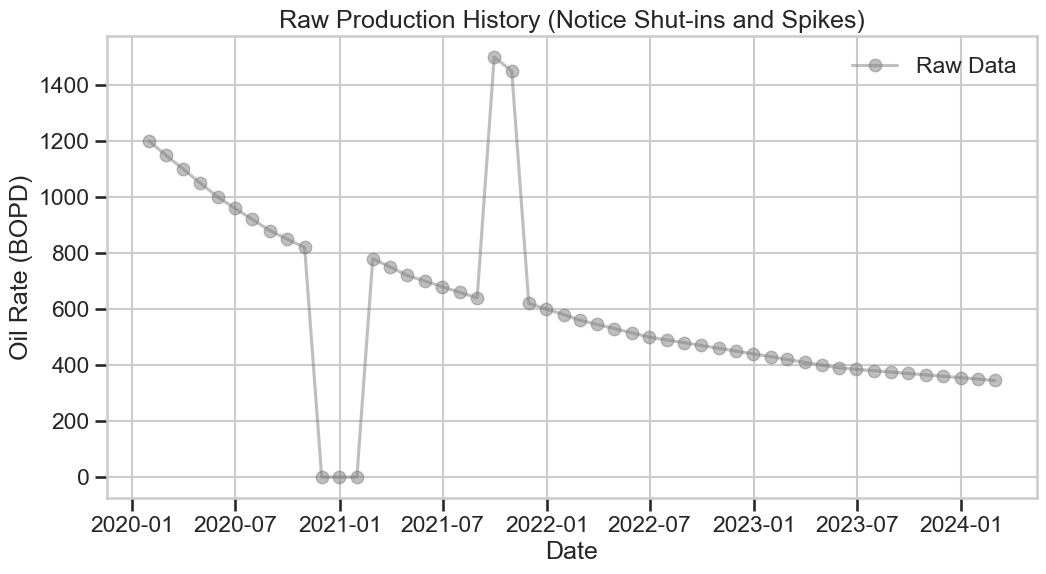

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Oil_Rate_BOPD'], marker='o', linestyle='-', color='grey', alpha=0.5, label='Raw Data')
plt.title('Raw Production History (Notice Shut-ins and Spikes)')
plt.ylabel('Oil Rate (BOPD)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [4]:
# 1. Filter out Shut-ins (Rate > 0)
clean_df = df[df['Oil_Rate_BOPD'] > 0].copy()

# 2. simple Outlier Removal (Simulation of "Physics Check")
# In reality, you might use Rolling Mean + 3*StdDev
# Here, we assume any rate > 1.5x the previous month is an error if well is in decline
clean_df['Rate_Change'] = clean_df['Oil_Rate_BOPD'].pct_change()
clean_df = clean_df[clean_df['Rate_Change'] < 0.5] # Drop spikes > 50% increase

print(f"Cleaned Dataset Shape: {clean_df.shape}")

Cleaned Dataset Shape: (45, 3)


In [5]:
# Reset index to ensure time starts at 0 for the first valid data point
clean_df = clean_df.sort_values(by='Date').reset_index(drop=True)

# Calculate continuous time steps (t)
# Option A: Simple index (if data is monthly)
clean_df['t_index'] = clean_df.index 

# Option B: Days since start (More precise)
start_date = clean_df['Date'].min()
clean_df['Days_Online'] = (clean_df['Date'] - start_date).dt.days

print(clean_df[['Date', 'Oil_Rate_BOPD', 't_index', 'Days_Online']].head())

        Date  Oil_Rate_BOPD  t_index  Days_Online
0 2020-02-29           1150        0            0
1 2020-03-31           1100        1           31
2 2020-04-30           1050        2           61
3 2020-05-31           1000        3           92
4 2020-06-30            960        4          122


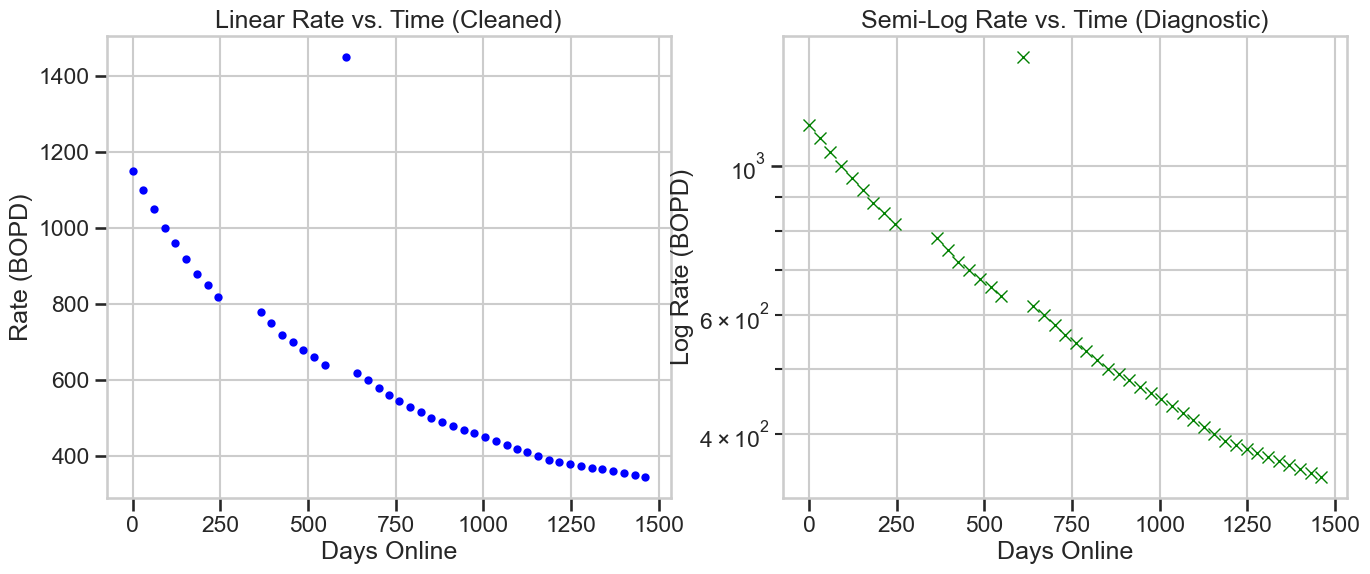

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Linear Plot (Cleaned)
ax[0].scatter(clean_df['Days_Online'], clean_df['Oil_Rate_BOPD'], color='blue', s=20)
ax[0].set_title('Linear Rate vs. Time (Cleaned)')
ax[0].set_ylabel('Rate (BOPD)')
ax[0].set_xlabel('Days Online')

# Semi-Log Plot
ax[1].semilogy(clean_df['Days_Online'], clean_df['Oil_Rate_BOPD'], color='green', marker='x', linestyle='none')
ax[1].set_title('Semi-Log Rate vs. Time (Diagnostic)')
ax[1].set_ylabel('Log Rate (BOPD)')
ax[1].set_xlabel('Days Online')
ax[1].grid(True, which="both", ls="-")

plt.show()

In [8]:
# Save to processed folder for the next notebook (Optimization)
# clean_df.to_csv('../data/processed/cleaned_production_data.csv', index=False)
print("Data cleaned and saved successfully.")

Data cleaned and saved successfully.
